# Resnet Mode

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h2 = h2

    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h2(x))

class H4Layer(Layer):
    def __init__(self, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h3(x))    
    
class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    elif degree ==4:
        return x**4
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

def resnet_block(x, filters, activation_1, activation_2, rank=None):
    
    h1 = H1Layer()
    h2 = H2Layer(h1)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    return x

def build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_1, activation_2, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
# activation_1 = tf.keras.activations.relu
activation_1 = lambda x: polynomial_activation(x, degree=1)
#activation_2 = tf.keras.activations.linear
activation_2 = lambda x: polynomial_activation(x, degree=1)

rank = 2

model = build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank)
optimizer = Adam(learning_rate=0.00001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


* Just uses up to n= 2
* When applied Higher values explode and predictions become NAN

* Just trained for 300 epochs, good results appear before 100

In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
#lower_bound = -10
#upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 300

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 0.1730 - val_loss: 3.9989e-04
Epoch 2/300
125/125 [==============================] - 0s 964us/step - loss: 2.9773e-04 - val_loss: 2.5815e-04
Epoch 3/300
125/125 [==============================] - 0s 972us/step - loss: 2.0898e-04 - val_loss: 1.9536e-04
Epoch 4/300
125/125 [==============================] - 0s 956us/step - loss: 3.9800e-04 - val_loss: 2.2846e-04
Epoch 5/300
125/125 [==============================] - 0s 939us/step - loss: 2.4234e-04 - val_loss: 2.2109e-04
Epoch 6/300
125/125 [==============================] - 0s 985us/step - loss: 3.6755e-04 - val_loss: 1.9032e-04
Epoch 7/300
125/125 [==============================] - 0s 948us/step - loss: 2.4413e-04 - val_loss: 2.9657e-04
Epoch 8/300
125/125 [==============================] - 0s 938us/step - loss: 3.5292e-04 - val_loss: 2.3761e-04
Epoch 9/300
125/125 [==============================] - 0s 936us/step - loss: 5.9089e-04 - val_loss: 7.3954e-04
Epoch 1

Validation loss: 0.00038418357144109905
32/32 [==============================] - 0s 515us/step


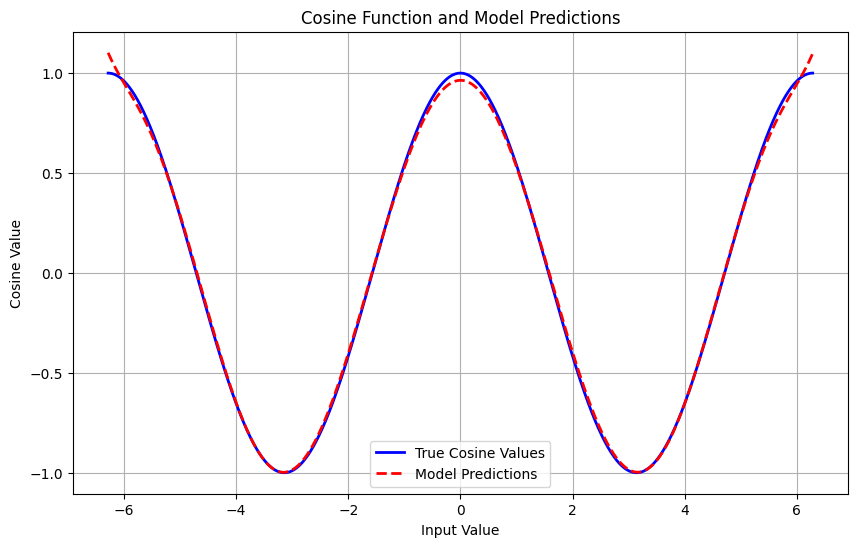

In [3]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Validation loss: 0.00038

# LAYER MODE

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return(2*x*(self.h4(x)))-(8*self.h3(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.000001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


* n = 4
* Values does not explode since it is just one layer of each, On resnet it repeats the number of blocks
* Has to be trained arround 600 epochs to get proper results

In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 600

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/600
125/125 [==============================] - 2s 3ms/step - loss: 0.4941 - val_loss: 0.5168
Epoch 2/600
125/125 [==============================] - 0s 1ms/step - loss: 0.1532 - val_loss: 0.0047
Epoch 3/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 9.3716e-04
Epoch 4/600
125/125 [==============================] - 0s 1ms/step - loss: 7.2256e-04 - val_loss: 4.1890e-04
Epoch 5/600
125/125 [==============================] - 0s 1ms/step - loss: 2.9709e-04 - val_loss: 1.3527e-04
Epoch 6/600
125/125 [==============================] - 0s 1ms/step - loss: 1.6738e-04 - val_loss: 1.5363e-04
Epoch 7/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 2.7602e-04
Epoch 8/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 1.1369e-04
Epoch 9/600
125/125 [==============================] - 0s 1ms/step - loss: 8.9262e-05 - val_loss: 7.4455e-05
Epoch 10/600
125/125 [=========================

Validation loss: 3.343156276969239e-05
32/32 [==============================] - 0s 800us/step


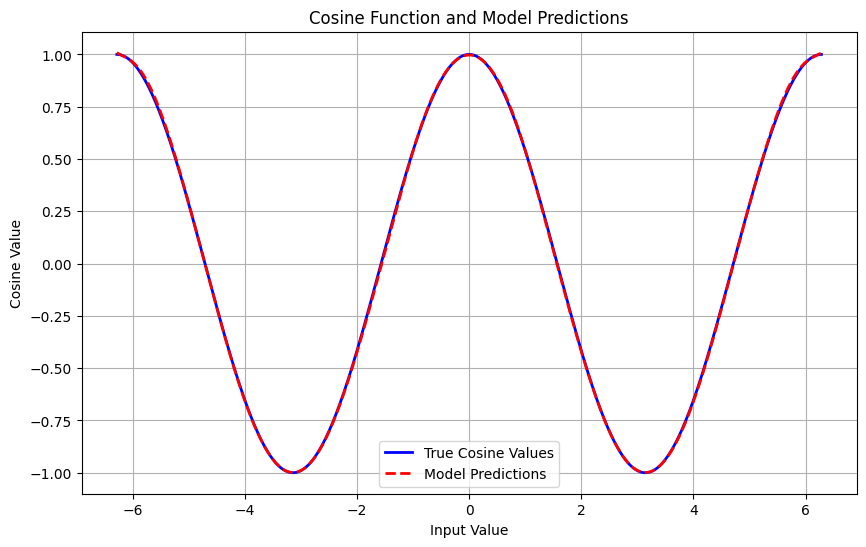

In [3]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Validation loss: 0.000011

# Higher Learning Rate

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return(2*x*(self.h4(x)))-(8*self.h3(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 600

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/600
125/125 [==============================] - 2s 3ms/step - loss: 0.4951 - val_loss: 0.5165
Epoch 2/600
125/125 [==============================] - 0s 1ms/step - loss: 0.1409 - val_loss: 0.0331
Epoch 3/600
125/125 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0324
Epoch 4/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0330
Epoch 5/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0340
Epoch 6/600
125/125 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0300
Epoch 7/600
125/125 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0323
Epoch 8/600
125/125 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0311
Epoch 9/600
125/125 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0312
Epoch 10/600
125/125 [==============================] - 0s 2ms/step - loss: 0.0318 - val_lo

Validation loss: 5.226326720730867e-06
32/32 [==============================] - 0s 1ms/step


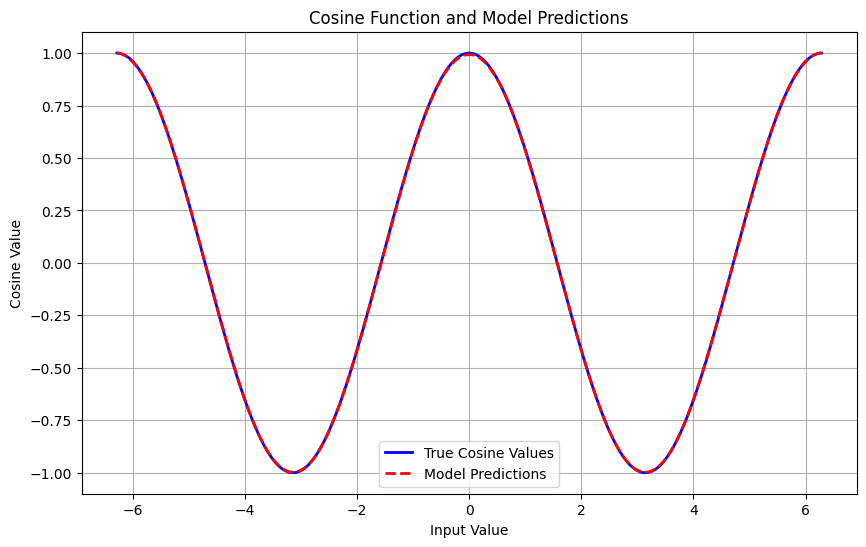

In [4]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Layer up to 6

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer=optimizer, loss='mse')


In [6]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 1.9143e-04
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0987 - val_loss: 0.0109
Epoch 3/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0103
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0440 - val_loss: 0.2489
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0477 - val_loss: 0.1874
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0767 - val_loss: 0.1684
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0032
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1126 - val_loss: 0.0169
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0638
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1346 - va

Validation loss: 5.015358328819275e-05
32/32 [==============================] - 0s 640us/step


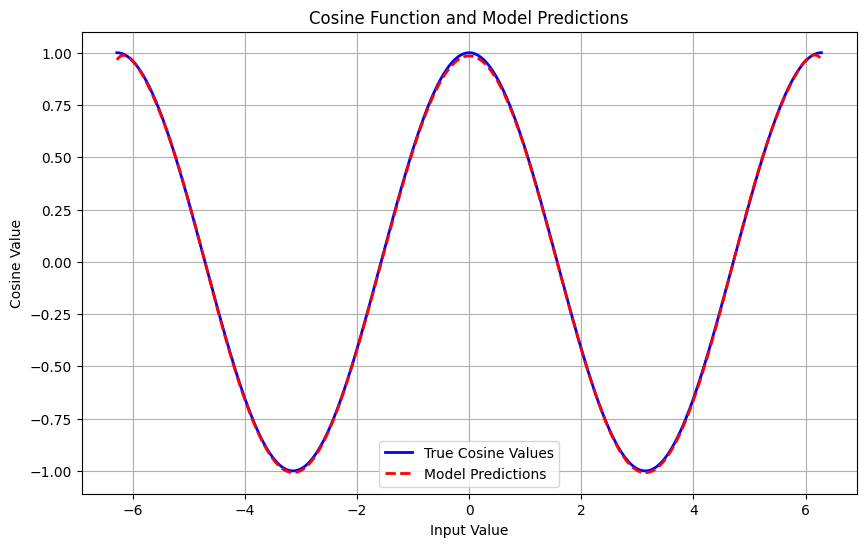

In [7]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Weights added

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.a = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.a * (2 * x)
        # return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H2Layer, self).build(input_shape)

    def call(self, x):
        return ((2*x*(self.h1(x)))-2)
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2

    def build(self, input_shape):
        self.c = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H3Layer, self).build(input_shape)
        
    def call(self, x):
        return ((2*x*(self.h2(x)))-(4*self.h1(x)))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def build(self, input_shape):
        self.d = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H4Layer, self).build(input_shape)

    def call(self, x):
        return ((2*x*(self.h3(x)))-(6*self.h2(x)))
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def build(self, input_shape):
        self.e = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H5Layer, self).build(input_shape)

    def call(self,x):
        return ((2*x*(self.h4(x)))-(8*self.h3(x)))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def build(self, input_shape):
        self.f = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H6Layer, self).build(input_shape)

    def call(self,x):
        return ((2*x*(self.h5(x)))-(10*self.h4(x)))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.0001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


In [5]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 2s 4ms/step - loss: 78.7835 - val_loss: 0.6265
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.5448 - val_loss: 0.5195
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4782 - val_loss: 0.4729
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4281 - val_loss: 0.3472
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3060 - val_loss: 0.3763
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2980 - val_loss: 0.3168
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2743 - val_loss: 0.2683
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 0.2511 - val_loss: 0.2778
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2246 - val_loss: 0.2074
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1867 - val_l

Validation loss: 0.0009113552514463663
32/32 [==============================] - 0s 720us/step


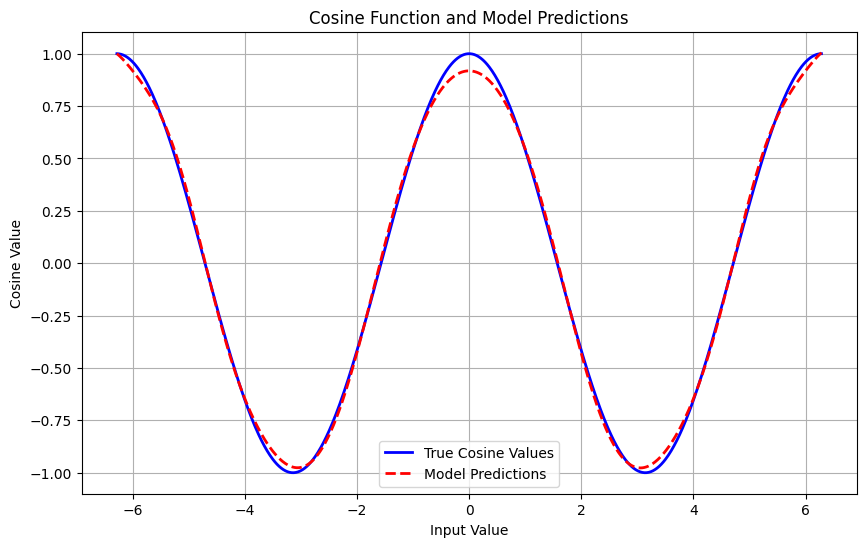

In [6]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Controlled Data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return(2*x*(self.h4(x)))-(8*self.h3(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer, loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
158/158 [==============================] - 2s 2ms/step - loss: 0.5007 - val_loss: 0.5042
Epoch 2/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4994 - val_loss: 0.5035
Epoch 3/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.5035
Epoch 4/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.5036
Epoch 5/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.5036
Epoch 6/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.5039
Epoch 7/200
158/158 [==============================] - 0s 1ms/step - loss: 0.5000 - val_loss: 0.5037
Epoch 8/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4994 - val_loss: 0.5035
Epoch 9/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.5035
Epoch 10/200
158/158 [==============================] - 0s 1ms/step - loss: 0.4993 - val_lo

Validation loss: 9.904878425004426e-06
32/32 [==============================] - 0s 587us/step


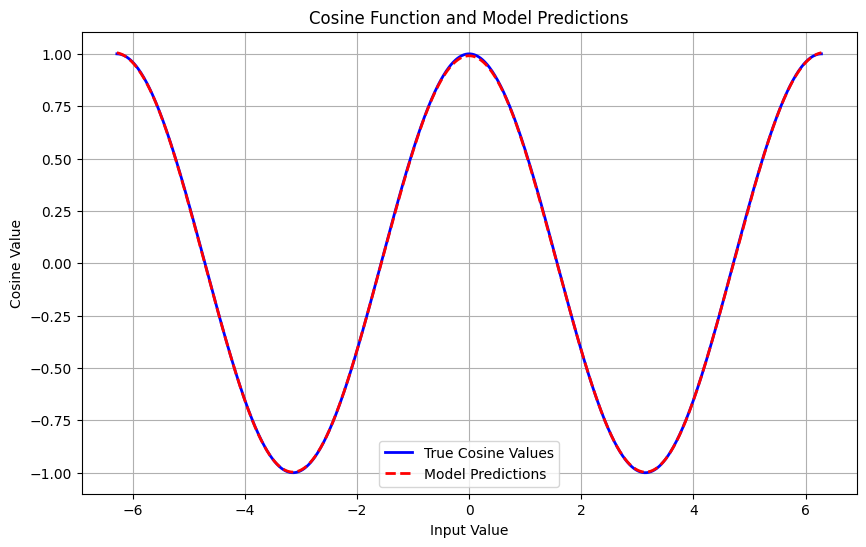

In [4]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Controlled Data Up to 6

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer=optimizer, loss='mse')


In [5]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 150

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/150
158/158 [==============================] - 0s 2ms/step - loss: 5.3311e-05 - val_loss: 1.9703e-05
Epoch 2/150
158/158 [==============================] - 0s 1ms/step - loss: 1.9729e-04 - val_loss: 5.0408e-05
Epoch 3/150
158/158 [==============================] - 0s 2ms/step - loss: 5.4301e-05 - val_loss: 2.6751e-05
Epoch 4/150
158/158 [==============================] - 0s 1ms/step - loss: 4.2439e-04 - val_loss: 1.5897e-04
Epoch 5/150
158/158 [==============================] - 0s 1ms/step - loss: 1.8060e-04 - val_loss: 6.1202e-06
Epoch 6/150
158/158 [==============================] - 0s 1ms/step - loss: 3.2445e-05 - val_loss: 2.7244e-04
Epoch 7/150
158/158 [==============================] - 0s 1ms/step - loss: 9.3775e-05 - val_loss: 0.0011
Epoch 8/150
158/158 [==============================] - 0s 1ms/step - loss: 3.0591e-04 - val_loss: 1.0722e-04
Epoch 9/150
158/158 [==============================] - 0s 1ms/step - loss: 1.3444e-05 - val_loss: 3.6077e-05
Epoch 10/150
158/158 [=

Validation loss: 6.969537207623944e-05
32/32 [==============================] - 0s 640us/step


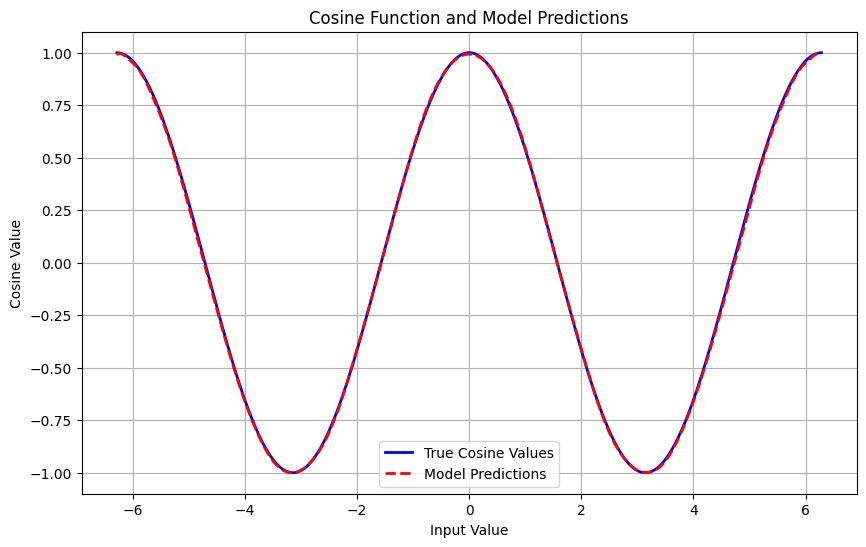

In [6]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# SGD Optimizer

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer=optimizer, loss='mse')


In [ ]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 100

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/100
158/158 [==============================] - 2s 3ms/step - loss: 0.5102 - val_loss: 0.5153
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5024 - val_loss: 0.5067
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5034 - val_loss: 0.5035
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5019 - val_loss: 0.5092
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5013 - val_loss: 0.5435
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5031 - val_loss: 0.5508
Epoch 7/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5021 - val_loss: 0.5077
Epoch 8/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5018 - val_loss: 0.5095
Epoch 9/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5006 - val_loss: 0.5103
Epoch 10/100
158/158 [==============================] - 0s 1ms/step - loss: 0.5025 - val_lo

Validation loss: 0.5085371732711792
32/32 [==============================] - 0s 688us/step


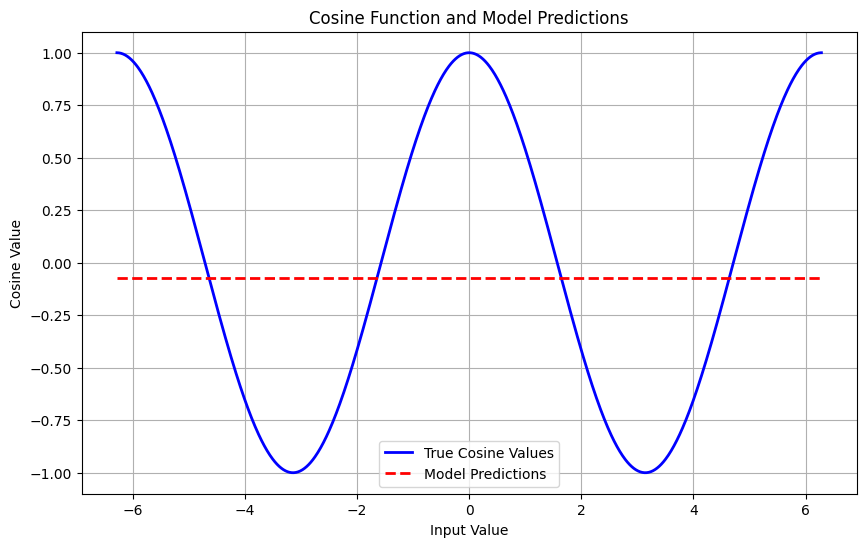

In [ ]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()
